In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk  # for NLP
import re  # import regex
from nltk.stem import PorterStemmer  # suffix stripping

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Machine Learning Encoding
from sklearn.preprocessing import LabelEncoder

In [2]:
# LSTM (Long Short Term Memory)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [3]:
train_data = pd.read_csv("/content/train.txt", header = None, sep = ';', names = ["Comment", "Emotion"], encoding="utf-8")

train_data['length'] = [len(x) for x in train_data['Comment']]

In [4]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [5]:
train_data.shape

(16000, 3)

In [6]:
# Check if missing values
train_data.isnull().sum()

,0
Comment,0
Emotion,0
length,0


In [7]:
train_data.duplicated().sum()  # duplicated rows

1

There is 1 duplicated row

## Data Visualisation

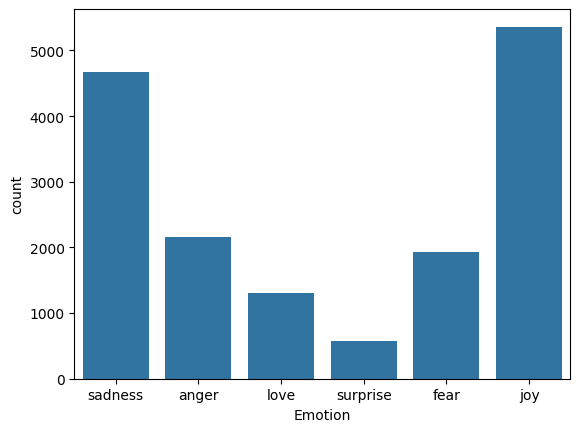

In [9]:
sns.countplot(x=train_data["Emotion"])
plt.show()

In [10]:
df2 = train_data.copy()
df2['length'] = [len(x) for x in train_data['Comment']]
length_value = df2['length'].value_counts()
length_value

,count
length,
71,155
50,153
69,153
52,145
44,141
...,...
279,2
300,1
7,1


In [11]:
print(df2['Emotion'])

0        sadness
1        sadness
2          anger
3           love
4          anger
          ...   
15995    sadness
15996    sadness
15997        joy
15998      anger
15999    sadness
Name: Emotion, Length: 16000, dtype: object


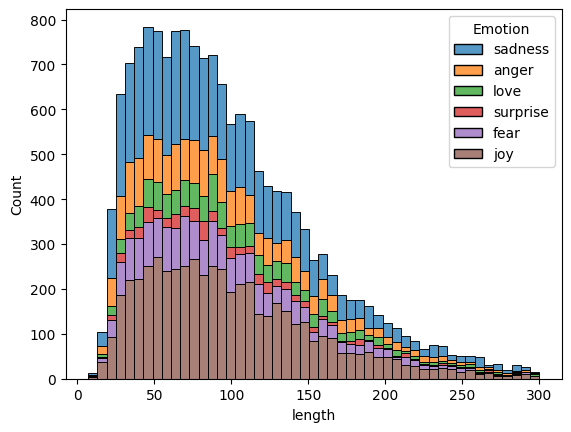

In [12]:
sns.histplot(data = df2, x = 'length', hue = 'Emotion', multiple = 'stack')
plt.show()

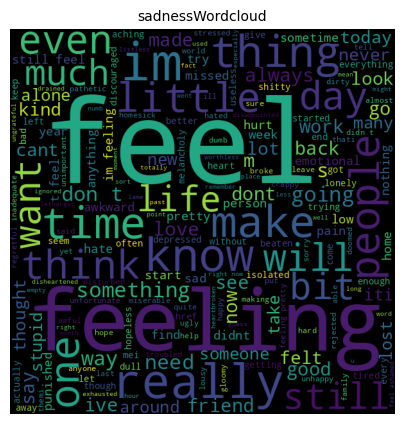

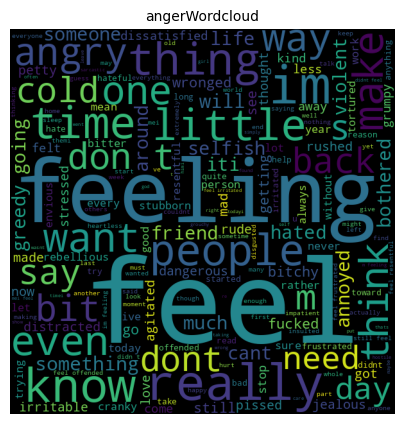

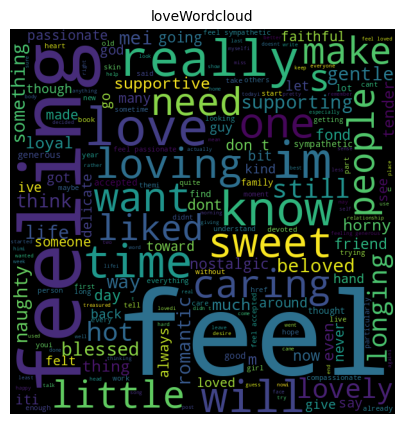

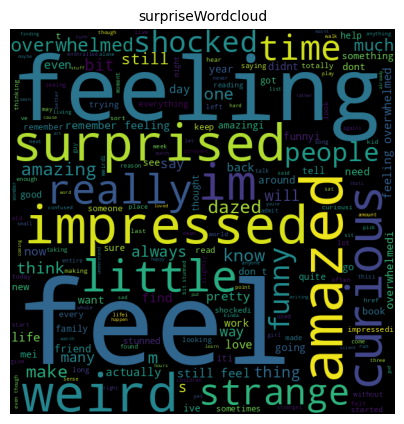

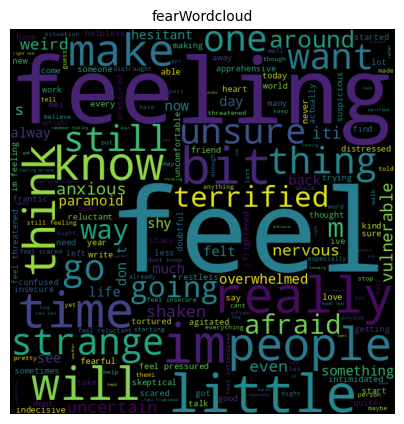

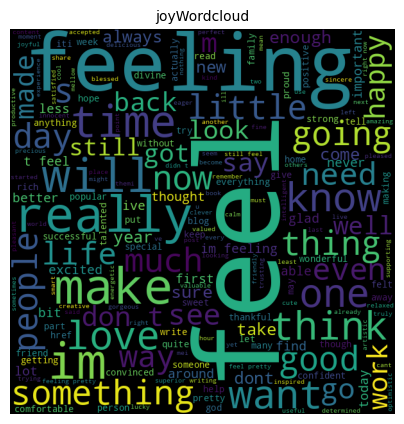

In [13]:
def words_cloud(wordcloud, df):
  plt.figure(figsize = (5, 5))
  plt.title(df + 'Wordcloud', size = 10)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
  text = ''.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion, 'Comment']])
  wordcloud = WordCloud(width = 600, height = 600).generate(text)
  words_cloud(wordcloud, emotion)

## Preprocessing

In [14]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [15]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Vectorization
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier
from sklearn.svm import SVC  # support vector classifier
from sklearn.metrics import accuracy_score, classification_report

In [17]:
df = train_data.copy()
df.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [19]:
# Track progress
from tqdm import tqdm
tqdm.pandas()
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

def clean_data(text):
  stemmer = PorterStemmer()
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = text.lower()  # remove uppercase
  text = text.split()  # split into words
  text = [stemmer.stem(word) for word in text if word not in stop_words]
  return ' '.join(text)

df['cleaned_comment'] = df['Comment'].progress_apply(clean_data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 16000/16000 [00:04<00:00, 3815.92it/s]


In [20]:
df.head()

,Comment,Emotion,length,cleaned_comment
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi


In [21]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['Emotion'], test_size=0.2, random_state=42)

In [22]:
tfidfvectorizer = TfidfVectorizer()
X_train_tfidf = tfidfvectorizer.fit_transform(X_train)
X_test_tfidf = tfidfvectorizer.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((12800, 9257), (3200, 9257))

In [23]:
# Computes various model after training to compare performance

classifier={
    'MultinomialNB':MultinomialNB(),
    'LogisticRegression':LogisticRegression(),
    'RandomForestClassifier':RandomForestClassifier(),
    'SVC':SVC()
}

for name,clf in classifier.items():
    clf.fit(X_train_tfidf,y_train)
    y_pred_tfidf=clf.predict(X_test_tfidf)
    print(f'{name} Accuracy: {accuracy_score(y_test,y_pred_tfidf)}')
    print(classification_report(y_test,y_pred_tfidf))

MultinomialNB Accuracy: 0.655
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200

LogisticRegression Accuracy: 0.829375
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
           4       0.88      0.92      0.90       946
           5       0.77      0.45      0.57       113

    accur

### Random forest is seen to perfom best

In [24]:
Rf = RandomForestClassifier()
Rf.fit(X_train_tfidf, y_train)
Rf_y_pred = Rf.predict(X_test_tfidf)
print(accuracy_score(y_test, Rf_y_pred))

0.8478125


In [25]:
def predict_emotion(input_text):
    input_text = clean_data(input_text)
    input_vector = tfidfvectorizer.transform([input_text])

    predicted_label = Rf.predict(input_vector)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]  # to get name of emotion
    label = np.argmax(Rf.predict(input_vector))

    return predicted_emotion, label

In [26]:
predict_emotion("You are the worst")

('anger', 0)

In [27]:
predict_emotion("You are amazing")

('surprise', 0)

In [28]:
predict_emotion("You are horrible")

('sadness', 0)

## LSTM Deep Learning

In [29]:
def clean_text_lstm(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []
    for text in df[column]:
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stop_words]
        text = ' '.join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text = words, n = vocab_size) for words in corpus]
    embedded_docs = pad_sequences(one_hot_word, padding = 'pre', maxlen = max_len)
    return embedded_docs

In [30]:
x_train = clean_text_lstm(train_data, 'Comment', vocab_size = 10000, max_len = 300)
y_train = to_categorical(train_data['Emotion'])

In [32]:
model = Sequential()
model.add(Embedding(input_dim = 10000, output_dim = 150, input_length = 300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=2, batch_size=64, verbose = 1, callbacks=[callback])

Epoch 1/2
250/250 ━━━━━━━━━━━━━━━━━━━━ 209s 801ms/step - accuracy: 0.3498 - loss: 1.5879
Epoch 2/2
250/250 ━━━━━━━━━━━━━━━━━━━━ 203s 804ms/step - accuracy: 0.7389 - loss: 0.8003


In [33]:
model.save("model.h5")

In [34]:
from tensorflow.keras.models import load_model
model1 = load_model("model.h5")

In [35]:
def predict_emotion_lstm(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub('[^a-zA-Z]', ' ', sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    text = ' '.join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text = words, n = 10000) for words in corpus]
    embedded_docs = pad_sequences(one_hot_word, padding = 'pre', maxlen = 300)
    predicted_label = np.argmax(model.predict(embedded_docs))
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    return predicted_emotion

In [40]:
sentence = predict_emotion_lstm("I am so excited")
preprocessed_sentence = clean_text_lstm(pd.DataFrame([sentence], columns=['Comment']), 'Comment', vocab_size=10000, max_len=300) # Preprocess the sentence
result = lb.inverse_transform(np.argmax(model.predict(preprocessed_sentence), axis = 1))[0]
prob = np.max(model1.predict(preprocessed_sentence))
print(f"Predicted emotion: {result} with probability of {prob}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Predicted emotion: joy with probability of 0.3840084373950958


In [43]:
sentence = predict_emotion_lstm("You are very mean")
preprocessed_sentence = clean_text_lstm(pd.DataFrame([sentence], columns=['Comment']), 'Comment', vocab_size=10000, max_len=300) # Preprocess the sentence
result = lb.inverse_transform(np.argmax(model.predict(preprocessed_sentence), axis = 1))[0]
prob = np.max(model1.predict(preprocessed_sentence))
print(f"Predicted emotion: {result} with probability of {prob}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Predicted emotion: anger with probability of 0.8618159294128418
